In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pymorphy2 import MorphAnalyzer
from nltk.corpus import stopwords
from multiprocessing import Pool
import tqdm
import re
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/simonyelisey/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [67]:
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')

In [68]:
target = 'grades'

## Read the data

In [56]:
train = pd.read_csv('data/train_ml.csv')
test = pd.read_csv('data/new_test_ml.csv', index_col='Unnamed: 0')

In [57]:
train.shape, test.shape

((75000, 4), (17220, 3))

## Preprocessing

### NaNs

In [58]:
train.isna().mean()

bank      0.000000
feeds     0.000000
grades    0.313653
date      0.000000
dtype: float64

In [59]:
train = train.dropna()

assert train.isna().sum().sum() == 0

### Target

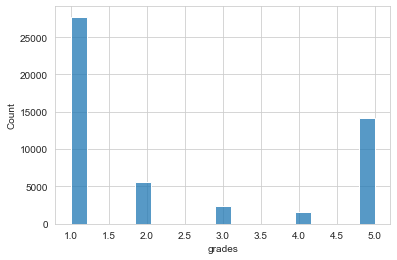

In [61]:
# target distribution

sns.histplot(train[target])
plt.show()

### Feeds

In [63]:
def count_words(data, text_column):
  """
  Function counts number of words and length of each object
  """
  data['text_len'] = data[text_column].apply(lambda x: len(x))
  data['num_words'] = data[text_column].apply(lambda x: len(x.split()))

  return data

In [64]:
train = count_words(train, 'feeds')
test = count_words(test, 'feeds')

In [ ]:
from functools import lru_cache

m = MorphAnalyzer()
regex = re.compile("[А-Яа-яA-z]+")

def words_only(text, regex=regex):
    try:
        return regex.findall(text.lower())
    except:
        return []

@lru_cache(maxsize=128)
def lemmatize_word(token, pymorphy=m):
    return pymorphy.parse(token)[0].normal_form

def lemmatize_text(text):
    return [lemmatize_word(w) for w in text]


mystopwords = stopwords.words('russian') 
def remove_stopwords(lemmas, stopwords = mystopwords):
    return [w for w in lemmas if not w in stopwords and len(w) > 3]

def clean_text(text):
    tokens = words_only(text)
    lemmas = lemmatize_text(tokens)
    
    return ' '.join(remove_stopwords(lemmas))

In [ ]:
# train

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, train['feeds']), total=len(train)))
    
train['lemmas'] = lemmas

100%|██████████| 51476/51476 [22:22<00:00, 38.34it/s]


In [ ]:
# save the train data

train.to_csv("data/preprocessed_train.csv", index=False)

In [ ]:
# test

with Pool(4) as p:
    lemmas = list(tqdm(p.imap(clean_text, test['feeds']), total=len(test)))
    
test['lemmas'] = lemmas

100%|██████████| 17220/17220 [07:45<00:00, 36.96it/s]


In [ ]:
# save the test data

test.to_csv("data/preprocessed_test.csv", index=False)